In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout,GRU
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
physical_devices = tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')

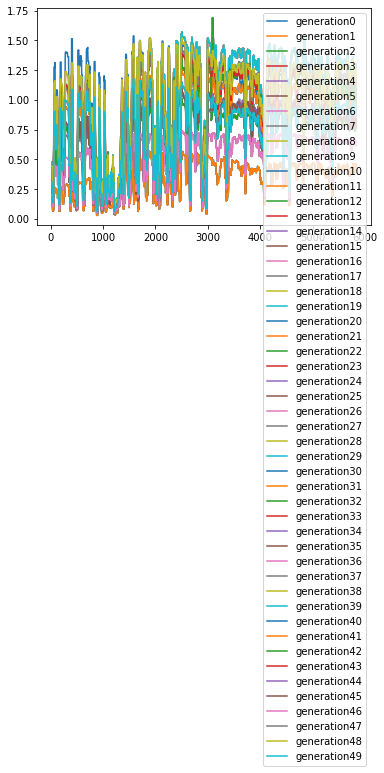

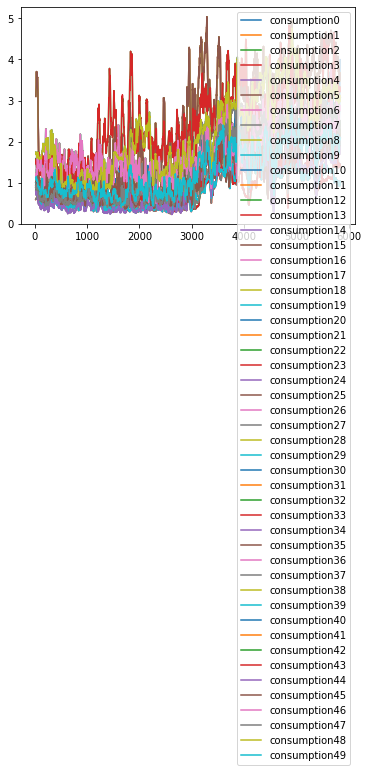

In [3]:
directory = 'training_data'
gens = pd.DataFrame()
cons = pd.DataFrame()
for i, filename in enumerate(os.listdir(directory)):
    target = pd.read_csv(os.path.join(directory, filename))
    gens['generation{}'.format(i)] = target['generation']
    cons['consumption{}'.format(i)] = target['consumption']

plt.rcParams["figure.figsize"] = (12, 12)

x=np.arange(len(gens))
for gen in gens:
    plt.plot(x, gens[gen].rolling(window=24).mean(), label=gen)
plt.legend()
plt.show()
for con in cons:
    plt.plot(x, cons[con].rolling(window=24).mean(), label=con)
plt.legend()
plt.show()

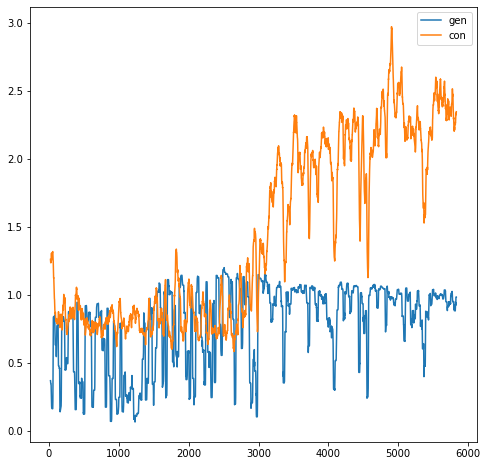

In [4]:
directory = 'training_data'
gens = pd.DataFrame()
cons = pd.DataFrame()
for i, filename in enumerate(os.listdir(directory)):
    target = pd.read_csv(os.path.join(directory, filename))
    gens['generation{}'.format(i)] = target['generation']
    cons['consumption{}'.format(i)] = target['consumption']

genAvg = []
conAvg = []
for rowIdx, gen in gens.iterrows():
    genAvg.append(np.sum(gen)/len(gen))
for rowIdx, con in cons.iterrows():
    conAvg.append(np.sum(con)/len(con))
    
genData = pd.DataFrame(np.array(genAvg))
conData = pd.DataFrame(np.array(conAvg))

plt.rcParams["figure.figsize"] = (8, 8)
plt.plot(x, genData.rolling(window=24).mean(), label='gen')
plt.plot(x, conData.rolling(window=24).mean(), label='con')
plt.legend()
plt.show()

In [5]:
# read data then seperate generation and consumption
# get the average of per hours of generation & consumption datas as the data
def getData(directory):
    gens = pd.DataFrame()
    cons = pd.DataFrame()
    for i, filename in enumerate(os.listdir(directory)):
        target = pd.read_csv(os.path.join(directory, filename))
        gens['generation{}'.format(i)] = target['generation']
        cons['consumption{}'.format(i)] = target['consumption']
    genAvg = []
    conAvg = []
    for rowIdx, gen in gens.iterrows():
        genAvg.append(np.sum(gen)/len(gen))
    for rowIdx, con in cons.iterrows():
        conAvg.append(np.sum(con)/len(con))
    return pd.DataFrame(np.array(genAvg)), pd.DataFrame(np.array(conAvg))

def createDataset(dataset, ref_day = 1):
    X, Y = [], []
    end = len(dataset)-((ref_day)*24+1)
    for i in range(0, end, 24):
        X.append(dataset[i:(i + (ref_day)*24)])
        Y.append(dataset[(i + (ref_day)*24):(i + (ref_day)*24 + 1)])
    return np.array(X), np.array(Y)

In [6]:
def createDataset(dataset, ref_day = 1):
    X, Y = [], []
    end = len(dataset)-((ref_day+1)*24)
    for i in range(0, end, 24):
        X.append(dataset[i:(i + (ref_day)*24)])
        Y.append(dataset[(i + (ref_day)*24):(i + (ref_day+1)*24)])
    return np.array(X), np.array(Y)

In [7]:
def splitData(X, Y, ref_day = 1, splitSize = 0.8):
    train_size = int(len(X) * splitSize)
    test_size = len(X) - train_size
#     print('train size : ', train_size)
#     print('test size : ', test_size)
    X_train = X[:train_size]
    Y_train = Y[:train_size]
    X_test = X[train_size:]
    Y_test = Y[train_size:]

    X_train = X_train.reshape(-1, 1, ref_day*24)
    Y_train = Y_train.reshape(-1, 1, 24)
    X_test = X_test.reshape(-1, 1, ref_day*24)
    Y_test = Y_test.reshape(-1, 1, 24)
    return X_train, Y_train, X_test, Y_test

In [8]:
def modelBuilding(shape):
    model = tf.keras.Sequential()
    # First GRU layer with dropout
    model.add(GRU(units=64, return_sequences=True, input_shape=(shape[1],shape[2]), activation = 'tanh'))
    model.add(Dropout(0.2))
    # Second GRU layer with dropout
    model.add(GRU(units=64, return_sequences=True, activation = 'tanh'))
    model.add(Dropout(0.2))
    # Third GRU layer with dropout
    model.add(GRU(units=64, return_sequences=True, activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(24))
    print(model.summary())
    return model

In [9]:
def plotPerformance(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'red', label='Training Loss')
    plt.plot(epochs, val_loss, 'blue', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [20]:
directory = 'training_data'
ref_day = 3
splitSize = 0.8

generation, consumption = getData(directory)

In [21]:
gScalar = MinMaxScaler()

generation = gScalar.fit_transform(generation)

genX, genY = createDataset(generation, ref_day)
gen_Xtrain, gen_Ytrain, gen_Xtest, gen_Ytest = splitData(genX, genY, ref_day, splitSize)
gen_Xtrain, gen_Ytrain, gen_Xval, gen_Yval = splitData(gen_Xtrain, gen_Ytrain, ref_day, 0.875)
gen_Xtrain.shape, gen_Ytrain.shape, gen_Xval.shape, gen_Yval.shape, gen_Xtest.shape, gen_Ytest.shape

((167, 1, 72),
 (167, 1, 24),
 (24, 1, 72),
 (24, 1, 24),
 (48, 1, 72),
 (48, 1, 24))

In [12]:
generationM = modelBuilding(gen_Xtrain.shape)
generationM.compile(
        tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss='mean_squared_error'
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 64)             26496     
_________________________________________________________________
dropout (Dropout)            (None, 1, 64)             0         
_________________________________________________________________
gru_1 (GRU)                  (None, 1, 64)             24960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
gru_2 (GRU)                  (None, 1, 64)             24960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 24)             1

Epoch 1/100
3/3 [==============================] - 13s 2s/step - loss: 0.0947 - val_loss: 0.0912
Epoch 2/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0623 - val_loss: 0.0405
Epoch 3/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0356 - val_loss: 0.0202
Epoch 4/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0300 - val_loss: 0.0190
Epoch 5/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0296 - val_loss: 0.0158
Epoch 6/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0280 - val_loss: 0.0196
Epoch 7/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0285 - val_loss: 0.0134
Epoch 8/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0270 - val_loss: 0.0134
Epoch 9/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0270 - val_loss: 0.0140
Epoch 10/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0255 - val_loss: 0.0145
Epoch 11/100
3/3 [==

Epoch 84/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0177 - val_loss: 0.0116
Epoch 85/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0186 - val_loss: 0.0116
Epoch 86/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0179 - val_loss: 0.0116
Epoch 87/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0180 - val_loss: 0.0115
Epoch 88/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0177 - val_loss: 0.0119
Epoch 89/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0174 - val_loss: 0.0118
Epoch 90/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0176 - val_loss: 0.0116
Epoch 91/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0171 - val_loss: 0.0124
Epoch 92/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0173 - val_loss: 0.0126
Epoch 93/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0172 - val_loss: 0.0121
Epoch 94/1

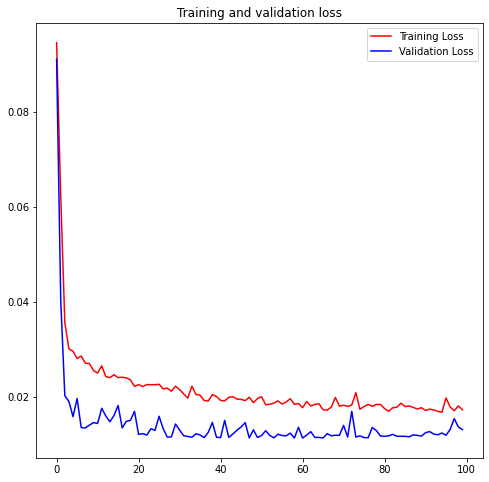

In [13]:
genHist = generationM.fit(gen_Xtrain, gen_Ytrain,
                        validation_data=(gen_Xval, gen_Yval),
                        epochs=100,
                        batch_size=64
                        )
plotPerformance(genHist)

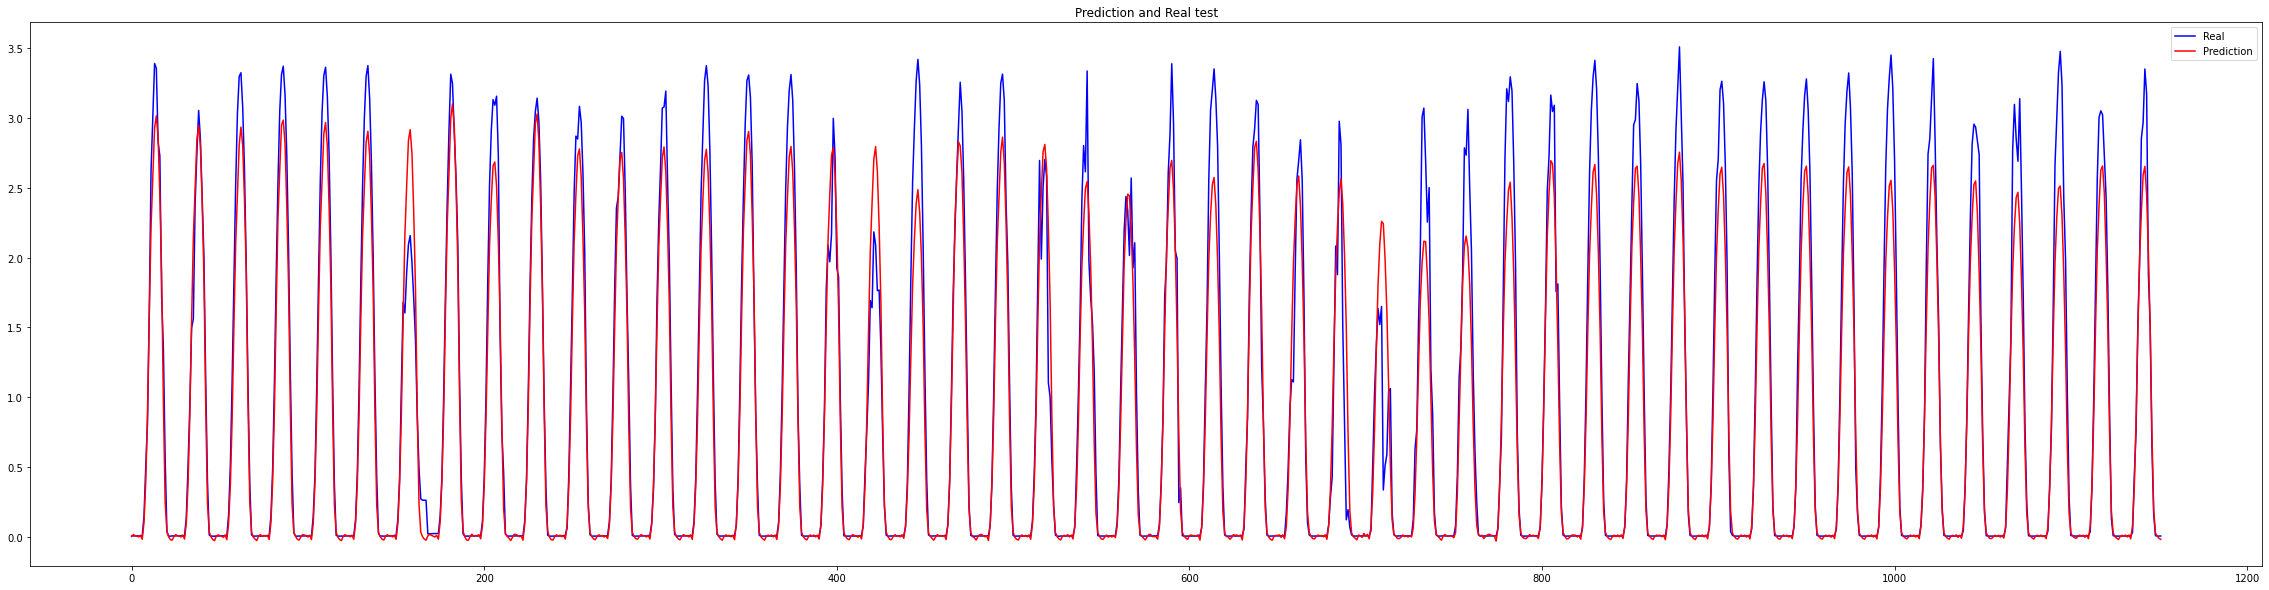

In [14]:
prediction = generationM.predict(gen_Xtest)
prediction = prediction.reshape(-1,1)
predictionGInverse = gScalar.inverse_transform(prediction)
predictionGInverse = predictionGInverse.reshape(-1)
gen_Ytest = gen_Ytest.reshape(-1,1)
real_gen = gScalar.inverse_transform(gen_Ytest)

time = range(len(gen_Ytest))
plt.figure(figsize=(40,10))
plt.plot(time, real_gen, 'blue', label='Real')
plt.plot(time, predictionGInverse, 'red', label='Prediction')
plt.title('Prediction and Real test')
plt.legend()

plt.show()

In [15]:
cScaler = MinMaxScaler()

consumption = cScaler.fit_transform(consumption)

conX, conY = createDataset(consumption, ref_day)
con_Xtrain, con_Ytrain, con_Xtest, con_Ytest = splitData(conX, conY, ref_day, splitSize)
con_Xtrain, con_Ytrain, con_Xval, con_Yval = splitData(con_Xtrain, con_Ytrain, ref_day, 0.875)

In [16]:
consumptionM = modelBuilding(con_Xtrain.shape)
consumptionM.compile(
        tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss='mean_squared_error'
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 1, 64)             26496     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
gru_4 (GRU)                  (None, 1, 64)             24960     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
gru_5 (GRU)                  (None, 1, 64)             24960     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 24)            

Epoch 1/100
3/3 [==============================] - 5s 534ms/step - loss: 0.0487 - val_loss: 0.1220
Epoch 2/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0286 - val_loss: 0.0487
Epoch 3/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0127 - val_loss: 0.0186
Epoch 4/100
3/3 [==============================] - 0s 49ms/step - loss: 0.0092 - val_loss: 0.0168
Epoch 5/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0094 - val_loss: 0.0136
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0089 - val_loss: 0.0183
Epoch 7/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0089 - val_loss: 0.0156
Epoch 8/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0086 - val_loss: 0.0119
Epoch 9/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0080 - val_loss: 0.0224
Epoch 10/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0081 - val_loss: 0.0125
Epoch 11/100
3/3 [

Epoch 84/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0043 - val_loss: 0.0105
Epoch 85/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0046 - val_loss: 0.0096
Epoch 86/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0062 - val_loss: 0.0141
Epoch 87/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0046 - val_loss: 0.0100
Epoch 88/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0047 - val_loss: 0.0101
Epoch 89/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0049 - val_loss: 0.0100
Epoch 90/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0045 - val_loss: 0.0096
Epoch 91/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0047 - val_loss: 0.0121
Epoch 92/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0041 - val_loss: 0.0111
Epoch 93/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0046 - val_loss: 0.0187
Epoch 94/1

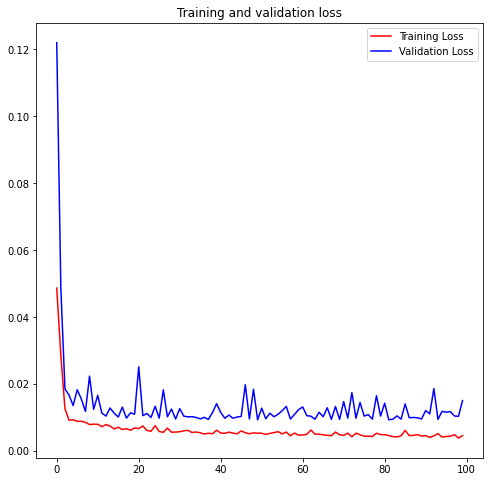

In [17]:
conHist = consumptionM.fit(con_Xtrain, con_Ytrain,
                        validation_data=(con_Xval, con_Yval),
                        epochs=100,
                        batch_size=64
                        )
plotPerformance(conHist)

(1152, 1) (1152, 1)


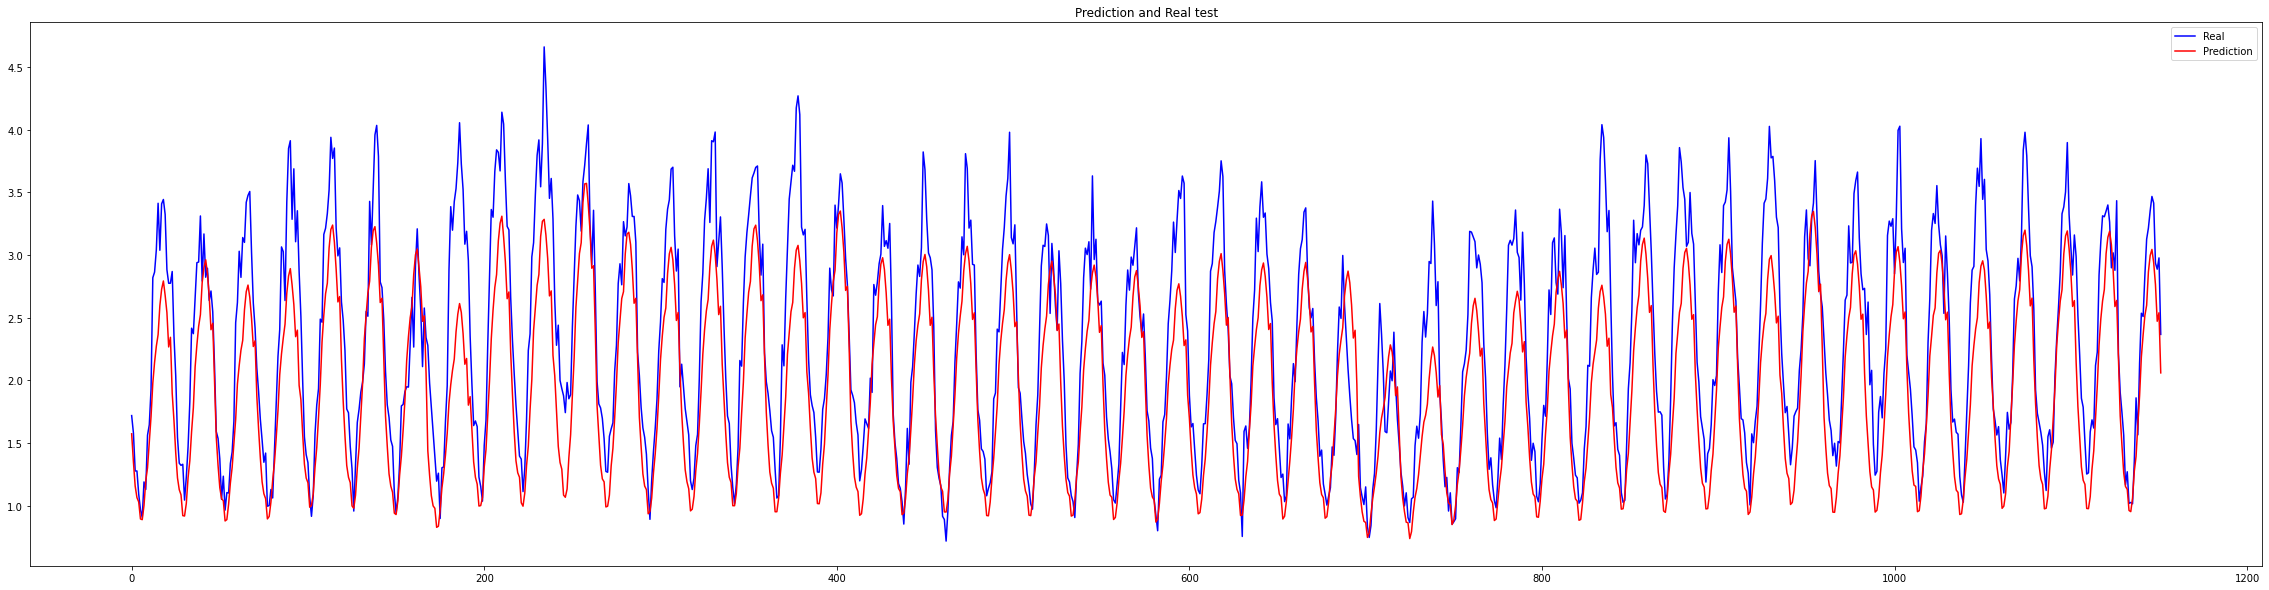

In [18]:
predictionC = consumptionM.predict(con_Xtest)
predictionC = predictionC.reshape(-1,1)
predictionCInverse = cScaler.inverse_transform(predictionC)
predictionCInverse = predictionCInverse.reshape(-1)
# predictionC = predictionC.reshape(-1)
con_Ytest = con_Ytest.reshape(-1,1)
real_con = cScaler.inverse_transform(con_Ytest)
print(predictionC.shape, con_Ytest.shape)

time = range(len(real_con))
plt.figure(figsize=(40,10))
plt.plot(time, real_con, 'blue', label='Real')
plt.plot(time, predictionCInverse, 'red', label='Prediction')
plt.title('Prediction and Real test')
plt.legend()

plt.show()

In [19]:
# generationM.save('generationModel_v1.h5')
# consumptionM.save('consumptionModel_v1.h5')